In [2]:
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.geometry import shape 
import matplotlib.pyplot as plt
import datetime
import sys
sys.path.append('../../Scripts/') # link to scripts
import preprocessing.translate   # import translation scripts from preprocessing
import utils.spatial_utils
import utils.temporal_utils

%matplotlib inline

In [3]:
# path to the MTL Trajet data 
path_2016 = "../../Data/mtl_trajet/mtl_trajet_2016.shp"
path_2017 = "../../Data/mtl_trajet/trajets_mtl_trajet_2017.shp"

In [3]:
############## Important ##############
# Note: Script below is used to deal with raw MTL Trajet 2016 data ('trip final') and load into geopandas
# Reason: the data cannot be loaded in because there are invalid geometries

# ## FROM https://gis.stackexchange.com/questions/277231/geopandas-valueerror-a-linearring-must-have-at-least-3-coordinate-tuples
# import json
# import fiona
# path_2016 = "../CASA Projects/msc_dissertation_notebooks/app_route_data/MTL_Trajet_2016_SHP/trip_final/trip_final.shp"
# #Read data
# collection = list(fiona.open(path_2016,'r'))
# df1 = pd.DataFrame(collection)

# #Check Geometry
# def isvalid(geom):
#     try:
#         shape(geom)
#         return 1
#     except:
#         return 0
# df1['isvalid'] = df1['geometry'].apply(lambda x: isvalid(x))
# df1 = df1[df1['isvalid'] == 1]
# collection = json.loads(df1.to_json(orient='records'))

# #Convert to geodataframe
# gdf = gpd.GeoDataFrame.from_features(collection)

## save the file
# gdf.to_file("mtl_trajet/mtl_trajet_2016.shp", encoding='utf-8')
############## Important ##############

## Translate and Reproject the data

In [4]:
gdf_2016 = preprocessing.translate.translate_data(path_2016)
gdf_2017 = preprocessing.translate.translate_data(path_2017)

# initalise the CRS
if gdf_2016.crs == {}:
    print("initialising crs")
    gdf_2016.crs = {'init': 'epsg:4326'}
    
if gdf_2017.crs == {}:
    print("initialising crs")
    gdf_2017.crs = {'init': 'epsg:4326'}

initialising crs


In [5]:
# reproject data
if not gdf_2016.crs == {'init': 'epsg:3347'}:
    gdf_2016 = utils.spatial_utils.change_projection(gdf_2016)
    
if not gdf_2017.crs == {'init': 'epsg:3347'}:
    gdf_2017 = utils.spatial_utils.change_projection(gdf_2017)

translating data
translating data


In [6]:
gdf_2016.head(2)

,id_trip,avg_speed,duration,mode,purpose,n_coord,segments,starttime,endtime,geometry
0,1724206,4.4,460,walking,returning_home,12,"[{""id"": 1150192, ""source"": ""geobase_mtl""}, {""i...",2016-09-07T20:37:26-04,2016-09-07T20:45:06-04,LINESTRING (7628287.236741193 1247680.17623496...
1,1724208,10.7,2146,combination,work,120,"[{""id"": 1140016, ""source"": ""geobase_mtl""}, {""i...",2016-09-08T07:43:23-04,2016-09-08T08:19:09-04,LINESTRING (7627830.06960756 1247172.275532002...


In [7]:
gdf_2017.head(2)

,id_trip,mode,purpose,starttime,endtime,geometry
0,1547,None,None,2017-09-18 04:16:58UTC,2017-09-18 04:26:26UTC,LINESTRING (7624015.797731054 1247372.35912242...
1,308312,None,None,2017-09-18 06:17:46UTC,2017-09-18 06:58:49UTC,LINESTRING (7624029.565886395 1247375.82561127...


## analyse data

In [8]:
print(len(gdf_2016.dropna(subset=['mode'])))
print(len(gdf_2016.dropna(subset=['purpose'])))

57879
57879


In [9]:
print(len(gdf_2017.dropna(subset=['mode'])))
print(len(gdf_2017.dropna(subset=['purpose'])))

74218
74218


In [10]:
gdf_2017['purpose'].value_counts()

returning_home      27128
work                19241
leisure              9379
shops                8554
food_drink           3189
education            2830
pick_up_drop_off     1592
other                1219
health               1061
not_available          25
Name: purpose, dtype: int64

In [11]:
gdf_2016['purpose'].value_counts()

returning_home      16187
work                15474
leisure              7552
food_drink           5858
shops                5759
pick_up_drop_off     2521
education            2333
health               2195
Name: purpose, dtype: int64

In [12]:
gdf_2016['mode'].value_counts()

car                      33927
public_transport         12706
walking                   3956
cycling                   3830
public_transport, car     1584
combination               1379
other                      497
Name: mode, dtype: int64

In [13]:
gdf_2017['mode'].value_counts()[:10]

car                               24744
cycling                           13595
public_transport                  12935
walking                           11062
walking, public_transport          6234
public_transport, car               948
car_sharing                         908
walking, cycling                    766
walking, public_transport, car      567
walking, car                        494
Name: mode, dtype: int64

## Time zone changes

In [14]:
type(gdf_2016.starttime[0])

str

In [15]:
print("Min:", gdf_2016.starttime.min(), " Max:", gdf_2016.starttime.max())
print("Min:", gdf_2017.starttime.min(), " Max:", gdf_2017.starttime.max())

Min: 2016-09-02T22:46:55-04  Max: 2016-12-14T23:31:37-05
Min: 2017-09-18 04:16:58UTC  Max: 2017-10-18 03:50:08UTC


In [16]:
if not type(gdf_2016.starttime[0]) == datetime.datetime or not type(gdf_2017.starttime[0]) == datetime.datetime:
    print("converting start and end timestamps to datetime objects")
    gdf_2016['starttime'] = pd.to_datetime(gdf_2016['starttime'])
    gdf_2016['endtime'] = pd.to_datetime(gdf_2016['endtime'])
    gdf_2017['starttime'] = pd.to_datetime(gdf_2017['starttime'])
    gdf_2017['endtime'] = pd.to_datetime(gdf_2017['endtime'])

converting start and end timestamps to datetime objects


In [17]:
gdf_2016['starttime'].apply(lambda dt: dt.tzinfo).value_counts()
# 2 time zones 

tzoffset(None, -14400)    176346
tzoffset(None, -18000)     99278
Name: starttime, dtype: int64

In [18]:
gdf_2017['starttime'].apply(lambda dt: dt.tzinfo).value_counts()

UTC    185285
Name: starttime, dtype: int64

In [19]:
## replace time zone
gdf_2016['starttime'] = gdf_2016['starttime'].apply(lambda dt: dt.replace(tzinfo=None))
gdf_2016['endtime'] = gdf_2017['starttime'].apply(lambda dt: dt.replace(tzinfo=None))
gdf_2017['starttime'] = gdf_2016['endtime'].apply(lambda dt: dt.replace(tzinfo=None))
gdf_2017['endtime'] = gdf_2017['endtime'].apply(lambda dt: dt.replace(tzinfo=None))

## or
# gdf_2016 = utils.temporal_utils.remove_timezone(gdf_2016)
# gdf_2017 = utils.temporal_utils.remove_timezone(gdf_2017)

In [20]:
gdf_2016['starttime'].apply(lambda dt: dt.tzinfo).value_counts()

Series([], Name: starttime, dtype: int64)

In [21]:
gdf_2017['starttime'].apply(lambda dt: dt.tzinfo).value_counts()

Series([], Name: starttime, dtype: int64)

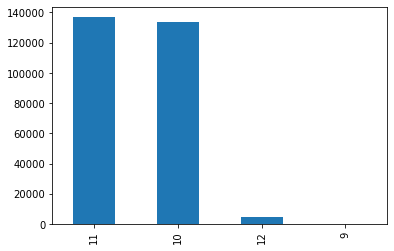

In [22]:
gdf_2016['starttime'].apply(lambda dt: dt.month).value_counts().plot(kind='bar')

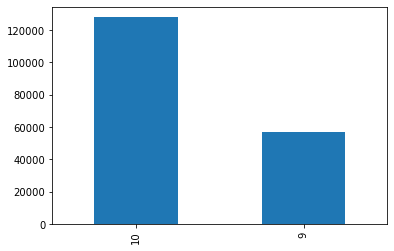

In [23]:
gdf_2017['starttime'].apply(lambda a: a.month).value_counts().plot(kind='bar')

In [24]:
print("Months for 2016:\n", gdf_2016['starttime'].apply(lambda a: a.month).value_counts(), "\n")
print("Months for 2017:\n", gdf_2017['starttime'].apply(lambda a: a.month).value_counts())

Months for 2016:
 11    137037
10    133795
12      4462
9        330
Name: starttime, dtype: int64 

Months for 2017:
 10    128148
9      57137
Name: starttime, dtype: int64


## save file

In [33]:
## convert datetime back to string
gdf_2016['starttime'] = gdf_2016['starttime'].astype(str)
gdf_2016['endtime'] = gdf_2016['endtime'].astype(str)
gdf_2017['starttime'] = gdf_2017['starttime'].astype(str)
gdf_2017['endtime'] = gdf_2017['endtime'].astype(str)

In [34]:
# gdf_2016.to_file("../../Data/mtl_trajet/mtl_trajet_2016_translated.shp", encoding='utf-8')
# gdf_2017.to_file("../../Data/mtl_trajet/mtl_trajet_2017_translated.shp", encoding='utf-8')
